In [ ]:
!pip install aif360
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 4.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.postprocessing import ThresholdOptimizer
from aif360.datasets import StandardDataset
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
df = pd.read_csv('compas-scores-two-years.csv')

In [ ]:
df2 = pd.read_csv('compas-scores-two-years.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [ ]:
df['decile_score'].unique()

array([ 4,  2,  1,  3,  8,  7,  6, 10,  9,  5])

# Data Cleaning

In [ ]:
columns = [
    'sex',
    'age',
    'race',
    'age_cat',  # Opcional
    'juv_fel_count',
    'juv_misd_count',
    'juv_other_count',
    'priors_count',
    'c_charge_degree',
    'c_charge_desc',
    'decile_score',
    'score_text',
    'two_year_recid'
]

df = df[columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              7214 non-null   object
 1   age              7214 non-null   int64 
 2   race             7214 non-null   object
 3   age_cat          7214 non-null   object
 4   juv_fel_count    7214 non-null   int64 
 5   juv_misd_count   7214 non-null   int64 
 6   juv_other_count  7214 non-null   int64 
 7   priors_count     7214 non-null   int64 
 8   c_charge_degree  7214 non-null   object
 9   c_charge_desc    7185 non-null   object
 10  decile_score     7214 non-null   int64 
 11  score_text       7214 non-null   object
 12  two_year_recid   7214 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 732.8+ KB


In [ ]:
df.head(5)

,sex,age,race,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,c_charge_desc,decile_score,score_text,two_year_recid
0,Male,69,Other,Greater than 45,0,0,0,0,F,Aggravated Assault w/Firearm,1,Low,0
1,Male,34,African-American,25 - 45,0,0,0,0,F,Felony Battery w/Prior Convict,3,Low,1
2,Male,24,African-American,Less than 25,0,0,1,4,F,Possession of Cocaine,4,Low,1
3,Male,23,African-American,Less than 25,0,1,0,1,F,Possession of Cannabis,8,High,0
4,Male,43,Other,25 - 45,0,0,0,2,F,arrest case no charge,1,Low,0


EDA

In [ ]:
df['score_text'].unique()

array(['Low', 'High', 'Medium'], dtype=object)

In [ ]:
df['c_charge_desc'].nunique()

437

In [ ]:
df['c_charge_degree'].unique()

array(['F', 'M'], dtype=object)

In [ ]:
df['c_charge_degree'].unique()

In [ ]:
df['priors_count'].unique()

array([ 0,  4,  1,  2, 14,  3,  7,  6,  5, 13,  8,  9, 21, 20, 15, 10, 12,
       28, 19, 11, 22, 23, 25, 24, 36, 18, 16, 33, 17, 30, 27, 38, 26, 37,
       29, 35, 31])

In [ ]:
df['age_cat'].unique()

array(['Greater than 45', '25 - 45', 'Less than 25'], dtype=object)

In [ ]:
df['race'].unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic',
       'Native American', 'Asian'], dtype=object)

<ipython-input-22-448c3d1beb2f>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  recid_by_agecat_race = df.groupby(['age_cat', 'race'])['two_year_recid'].mean().reset_index()


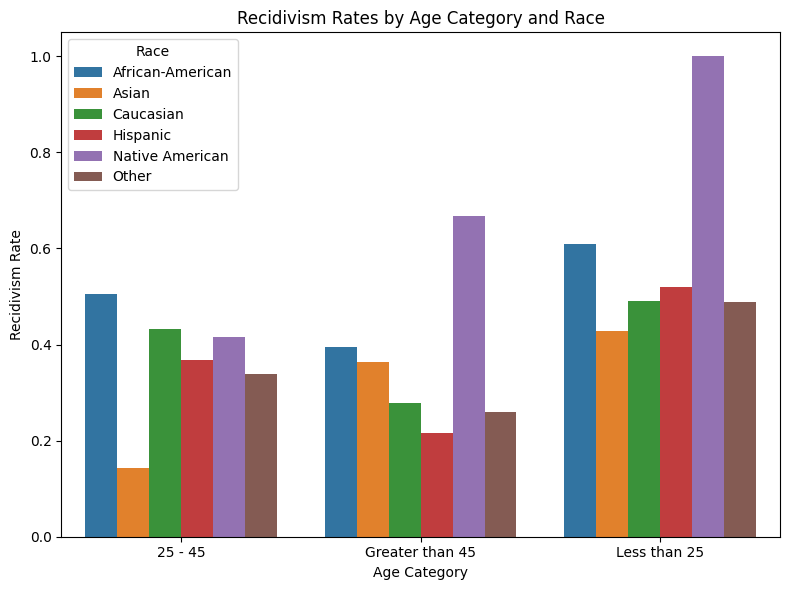

In [ ]:
# Group by age_cat and race, calculate recidivism rate
recid_by_agecat_race = df.groupby(['age_cat', 'race'])['two_year_recid'].mean().reset_index()

# Plot the recidivism rates across age categories
plt.figure(figsize=(8, 6))
sns.barplot(data=recid_by_agecat_race, x='age_cat', y='two_year_recid', hue='race')
plt.title('Recidivism Rates by Age Category and Race')
plt.ylabel('Recidivism Rate')
plt.xlabel('Age Category')
plt.legend(title='Race')
plt.tight_layout()
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              7214 non-null   object
 1   age              7214 non-null   int64 
 2   race             7214 non-null   object
 3   age_cat          7214 non-null   object
 4   juv_fel_count    7214 non-null   int64 
 5   juv_misd_count   7214 non-null   int64 
 6   juv_other_count  7214 non-null   int64 
 7   priors_count     7214 non-null   int64 
 8   c_charge_degree  7214 non-null   object
 9   c_charge_desc    7185 non-null   object
 10  decile_score     7214 non-null   int64 
 11  score_text       7214 non-null   object
 12  two_year_recid   7214 non-null   int64 
dtypes: int64(7), object(6)
memory usage: 732.8+ KB


In [ ]:
df.head(2)

,sex,race,age_cat,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,decile_score,score_text,two_year_recid
0,Male,Other,Greater than 45,0,0,0,0,F,1,Low,0
1,Male,African-American,25 - 45,0,0,0,0,F,3,Low,1


 One hot encode

In [ ]:
df = df.drop('c_charge_desc', axis=1)
df = df.drop('age', axis=1)

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              7214 non-null   object
 1   race             7214 non-null   object
 2   age_cat          7214 non-null   object
 3   juv_fel_count    7214 non-null   int64 
 4   juv_misd_count   7214 non-null   int64 
 5   juv_other_count  7214 non-null   int64 
 6   priors_count     7214 non-null   int64 
 7   c_charge_degree  7214 non-null   object
 8   decile_score     7214 non-null   int64 
 9   score_text       7214 non-null   object
 10  two_year_recid   7214 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 620.1+ KB


In [ ]:
df.columns

# Modelo Unfair

In [ ]:
X = df.drop(columns=['two_year_recid'])
y = df['two_year_recid']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo Logistic Regression
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

# Previsões
y_pred = model.predict(X_test)

# Avaliar o desempenho
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Pesos do modelo
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print("\nFeature Importance:\n", feature_importance)

Accuracy: 0.683991683991684

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.76      0.73       823
           1       0.64      0.59      0.62       620

    accuracy                           0.68      1443
   macro avg       0.68      0.67      0.67      1443
weighted avg       0.68      0.68      0.68      1443


Feature Importance:
                     Feature  Coefficient
15     age_cat_Less than 25     0.236348
2           juv_other_count     0.178533
4              decile_score     0.171462
0             juv_fel_count     0.115039
3              priors_count     0.091977
11     race_Native American     0.044714
1            juv_misd_count     0.028020
9            race_Caucasian    -0.007273
7     race_African-American    -0.066000
6                  sex_Male    -0.071043
12               race_Other    -0.076923
10            race_Hispanic    -0.092931
13          age_cat_25 - 45    -0.143306
19           score_text_

In [ ]:
native_american_rows = df2['race'] == 'Native American'

# 2. Select desired rows:
df2 = df2[~native_american_rows]

<ipython-input-39-efd1ff4797fe>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df2, x='race', y='decile_score', palette='Set2')


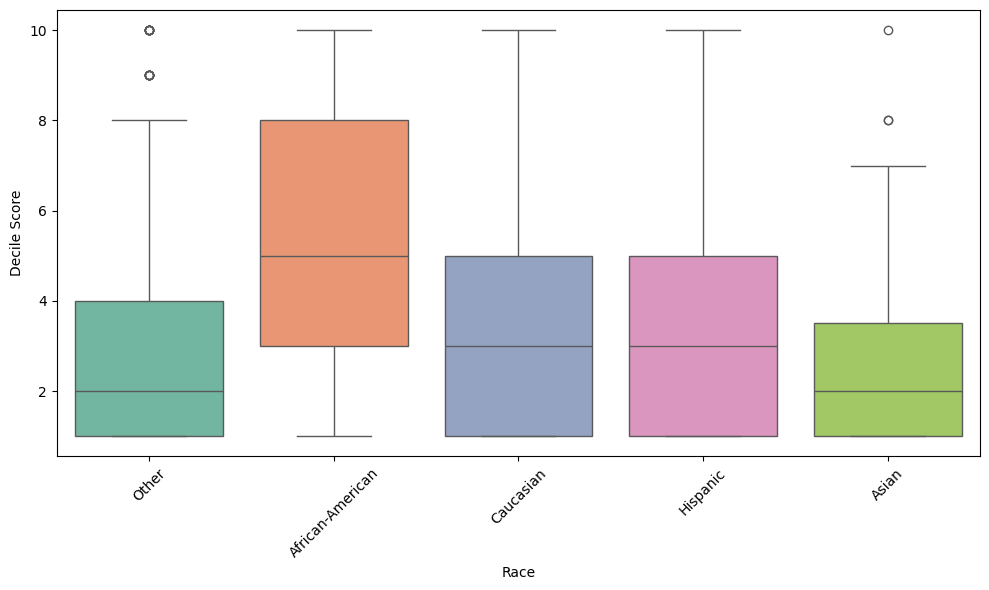

In [ ]:
# Assuming `df2` is your dataset
plt.figure(figsize=(10, 6))
sns.boxplot(data=df2, x='race', y='decile_score', palette='Set2')
plt.xlabel('Race')
plt.ylabel('Decile Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('decile_score_boxplot.png')  # Save as image
plt.show()

In [ ]:
# Separar os grupos sensíveis (raça) no conjunto de teste
race_groups = X_test[['race_African-American', 'race_Caucasian']]
y_test_array = y_test.to_numpy()

# Previsões do modelo
y_pred = model.predict(X_test)

# Função para calcular TPR (True Positive Rate) e FPR (False Positive Rate)
def calculate_rates(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    return TPR, FPR

# Filtrar as previsões por grupos sensíveis
def group_rates(group_mask, y_true, y_pred):
    group_y_true = y_true[group_mask]
    group_y_pred = y_pred[group_mask]
    return calculate_rates(group_y_true, group_y_pred)

# Máscaras para os grupos "African-American" e "Caucasian"
mask_african_american = race_groups['race_African-American'] == 1
mask_caucasian = race_groups['race_Caucasian'] == 1

# Calcular TPR e FPR para cada grupo
tpr_african_american, fpr_african_american = group_rates(mask_african_american, y_test_array, y_pred)
tpr_caucasian, fpr_caucasian = group_rates(mask_caucasian, y_test_array, y_pred)

# Calcular Average Odds Difference
average_odds_difference = 0.5 * ((tpr_african_american - tpr_caucasian) + (fpr_african_american - fpr_caucasian))

# Resultados
print(f"TPR African-American: {tpr_african_american:.3f}, FPR African-American: {fpr_african_american:.3f}")
print(f"TPR Caucasian: {tpr_caucasian:.3f}, FPR Caucasian: {fpr_caucasian:.3f}")
print(f"Average Odds Difference: {average_odds_difference:.3f}")


TPR African-American: 0.699, FPR African-American: 0.334
TPR Caucasian: 0.470, FPR Caucasian: 0.169
Average Odds Difference: 0.197


# Mitigando no Pré processamento

In [ ]:
# Carregar o dataset no formato do AIF360
protected_attribute = 'race_African-American'

# Criar o AIF360 Dataset
aif_data = StandardDataset(
    df,
    label_name='two_year_recid',
    favorable_classes=[0],  # Classe favorável (não reincidir)
    protected_attribute_names=[protected_attribute],
    privileged_classes=[[1]]  # Privilegiado: African-American = 1
)

# Aplicar o Reweighing
reweighing = Reweighing(unprivileged_groups=[{protected_attribute: 0}],
                        privileged_groups=[{protected_attribute: 1}])
reweighed_data = reweighing.fit_transform(aif_data)

# Obter os pesos
weights = reweighed_data.instance_weights

# Preparar X e y para treinamento
X_train = df.drop(columns=['two_year_recid'])
y_train = df['two_year_recid']

# Treinar o modelo Logistic Regression com os pesos ajustados
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train, sample_weight=weights)

# Previsões
y_pred = model.predict(X_test)

# Avaliação do modelo
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


Accuracy: 0.6770616770616771

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.76      0.73       823
           1       0.64      0.57      0.60       620

    accuracy                           0.68      1443
   macro avg       0.67      0.66      0.67      1443
weighted avg       0.67      0.68      0.67      1443



AVERAGE ODDS MITIGADO NO PRE PROCESSAMENTO

In [ ]:
tpr_african_american, fpr_african_american = group_rates(mask_african_american, y_test_array, y_pred)
tpr_caucasian, fpr_caucasian = group_rates(mask_caucasian, y_test_array, y_pred)

average_odds_difference = 0.5 * ((tpr_african_american - tpr_caucasian) + (fpr_african_american - fpr_caucasian))

print(f"TPR African-American: {tpr_african_american:.3f}, FPR African-American: {fpr_african_american:.3f}")
print(f"TPR Caucasian: {tpr_caucasian:.3f}, FPR Caucasian: {fpr_caucasian:.3f}")
print(f"Average Odds Difference: {average_odds_difference:.3f}")

TPR African-American: 0.597, FPR African-American: 0.234
TPR Caucasian: 0.589, FPR Caucasian: 0.259
Average Odds Difference: -0.009


# In processing

In [ ]:
protected_attribute = 'race_African-American'

aif_data = StandardDataset(
    df,
    label_name='two_year_recid',
    favorable_classes=[0],  # Classe favorável: Não reincidiu
    protected_attribute_names=[protected_attribute],
    privileged_classes=[[1]]  # Privilegiado: African-American
)

# Aplicar o Prejudice Remover
pr_model = PrejudiceRemover(sensitive_attr=protected_attribute, eta=0.5)
pr_model.fit(aif_data)

# Previsões no conjunto de teste
test_aif_data = StandardDataset(
    X_test.merge(y_test, left_index=True, right_index=True),
    label_name='two_year_recid',
    favorable_classes=[0],
    protected_attribute_names=[protected_attribute],
    privileged_classes=[[1]]
)

/usr/local/lib/python3.10/dist-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]
/usr/local/lib/python3.10/dist-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


In [ ]:
etas = [0.1, 0.3, 0.5, 1.0]

for eta in etas:
    print(f"\nTesting Prejudice Remover with eta = {eta}")
    pr_model = PrejudiceRemover(sensitive_attr=protected_attribute, eta=eta)
    pr_model.fit(aif_data)

    predictions = pr_model.predict(test_aif_data)
    y_pred = predictions.labels.ravel()

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.3f}")

    # Calcular Average Odds Difference
    tpr_african_american, fpr_african_american = group_rates(mask_african_american, y_test_array, y_pred)
    tpr_caucasian, fpr_caucasian = group_rates(mask_caucasian, y_test_array, y_pred)
    average_odds_difference = 0.5 * ((tpr_african_american - tpr_caucasian) + (fpr_african_american - fpr_caucasian))
    print(f"Average Odds Difference: {average_odds_difference:.3f}")



Testing Prejudice Remover with eta = 0.1
Accuracy: 0.308
Average Odds Difference: -0.214

Testing Prejudice Remover with eta = 0.3
Accuracy: 0.310
Average Odds Difference: -0.200

Testing Prejudice Remover with eta = 0.5
Accuracy: 0.310
Average Odds Difference: -0.200

Testing Prejudice Remover with eta = 1.0
Accuracy: 0.315
Average Odds Difference: -0.196


In [ ]:
# Calcular TPR e FPR para African-American
tpr_african_american, fpr_african_american = group_rates(mask_african_american, y_test_array, y_pred)

# Calcular TPR e FPR para Caucasian
tpr_caucasian, fpr_caucasian = group_rates(mask_caucasian, y_test_array, y_pred)

# Calcular Average Odds Difference
average_odds_difference = 0.5 * ((tpr_african_american - tpr_caucasian) + (fpr_african_american - fpr_caucasian))

# Resultados
print(f"TPR African-American: {tpr_african_american:.3f}, FPR African-American: {fpr_african_american:.3f}")
print(f"TPR Caucasian: {tpr_caucasian:.3f}, FPR Caucasian: {fpr_caucasian:.3f}")
print(f"Average Odds Difference: {average_odds_difference:.3f}")

TPR African-American: 0.309, FPR African-American: 0.671
TPR Caucasian: 0.524, FPR Caucasian: 0.856
Average Odds Difference: -0.200


# Post processing

In [ ]:
# Configurar o ThresholdOptimizer
equalized_odds = ThresholdOptimizer(
    estimator=model,  # Modelo já treinado
    constraints="equalized_odds",  # Garantir igualdade de odds
    prefit=True  # O modelo já foi treinado
)

# Treinar o ThresholdOptimizer no conjunto de validação
sensitive_features_train = X_train['race_African-American']
equalized_odds.fit(X_train, y_train, sensitive_features=sensitive_features_train)

# Fazer previsões ajustadas no conjunto de teste
sensitive_features_test = X_test['race_African-American']
y_pred_post = equalized_odds.predict(X_test, sensitive_features=sensitive_features_test)

# Avaliar o desempenho
print("Accuracy:", accuracy_score(y_test, y_pred_post))
print("\nClassification Report:\n", classification_report(y_test, y_pred_post))

/usr/local/lib/python3.10/dist-packages/fairlearn/postprocessing/_threshold_optimizer.py:285: FutureWarning: 'predict_method' default value is changed from 'predict' to 'auto'. Explicitly pass `predict_method='predict' to replicate the old behavior, or pass `predict_method='auto' or other valid values to silence this warning.
  warn(


Accuracy: 0.6666666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.76      0.72       823
           1       0.63      0.54      0.58       620

    accuracy                           0.67      1443
   macro avg       0.66      0.65      0.65      1443
weighted avg       0.66      0.67      0.66      1443



In [ ]:
def calculate_rates(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
    return TPR, FPR

# Máscaras para os grupos sensíveis
mask_african_american = X_test['race_African-American'] == 1
mask_caucasian = X_test['race_Caucasian'] == 1

# Calcular TPR e FPR para African-American
tpr_african_american, fpr_african_american = calculate_rates(
    y_test[mask_african_american],
    y_pred_post[mask_african_american]
)

# Calcular TPR e FPR para Caucasian
tpr_caucasian, fpr_caucasian = calculate_rates(
    y_test[mask_caucasian],
    y_pred_post[mask_caucasian]
)

# Calcular Average Odds Difference
average_odds_difference = 0.5 * ((tpr_african_american - tpr_caucasian) + (fpr_african_american - fpr_caucasian))

# Resultados
print(f"\nTPR African-American: {tpr_african_american:.3f}, FPR African-American: {fpr_african_american:.3f}")
print(f"TPR Caucasian: {tpr_caucasian:.3f}, FPR Caucasian: {fpr_caucasian:.3f}")
print(f"Average Odds Difference: {average_odds_difference:.3f}")


TPR African-American: 0.551, FPR African-American: 0.228
TPR Caucasian: 0.589, FPR Caucasian: 0.259
Average Odds Difference: -0.035
